In [112]:
import json
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import ast

ROOT_dir = Path('/Users/jliu/workspace/RAG')

# Zipfian with three-regime

In [114]:


def find_transition_point(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    window_size: int = 50,
    threshold_multiplier: float = 2.0,
    min_rank_percentile: float = 0.05,
    max_rank_percentile: float = 1.0,
    expected_direction: str = "any",  # "positive", "negative", or "any"
    min_log_rank: float = None,
    max_log_rank: float = None,
) -> dict:
    """
    Find a transition point using second derivative analysis with constraints.
    
    Parameters:
    -----------
    log_ranks: log-rank values
    log_vals: log-value data points
    window_size: window for calculating local slopes
    threshold_multiplier: sensitivity for detecting significant changes
    min_rank_percentile: minimum percentile to start analysis
    max_rank_percentile: maximum percentile to end analysis
    expected_direction: expected direction of second derivative ("positive", "negative", or "any")
    min_log_rank: minimum log rank to consider (direct constraint)
    max_log_rank: maximum log rank to consider (direct constraint)
    
    Returns:
    --------
    Dictionary with transition point information
    """
    n = len(log_ranks)
    info = {"transition_detected": False}
    
    # Apply rank percentile constraints
    min_idx = max(int(n * min_rank_percentile), window_size)
    max_idx = min(int(n * max_rank_percentile), n - window_size)
    
    # Apply direct log rank constraints if provided
    if min_log_rank is not None:
        min_rank_idx = np.where(log_ranks >= min_log_rank)[0]
        if len(min_rank_idx) > 0:
            min_idx = max(min_idx, min_rank_idx[0])
    
    if max_log_rank is not None:
        max_rank_idx = np.where(log_ranks <= max_log_rank)[0]
        if len(max_rank_idx) > 0:
            max_idx = min(max_idx, max_rank_idx[-1])
    
    # Ensure we have enough data points
    if max_idx <= min_idx + window_size:
        return info
    
    # Dynamic window size
    w = min(window_size, max(5, (max_idx - min_idx) // 5))
    
    # Calculate first derivatives (slopes)
    derivatives, idxs = [], []
    for i in range(min_idx, max_idx - w + 1):
        slope, _, _, _, _ = stats.linregress(
            log_ranks[i : i + w], log_vals[i : i + w]
        )
        derivatives.append(slope)
        idxs.append(i)
    
    derivatives = np.array(derivatives)
    
    # Calculate second derivatives (changes in slope)
    if len(derivatives) > 1:
        second_derivatives = np.diff(derivatives)
        
        # Apply direction constraint if specified
        if expected_direction == "positive":
            second_derivatives[second_derivatives <= 0] = 0
        elif expected_direction == "negative":
            second_derivatives[second_derivatives >= 0] = 0
        
        # Find significant changes
        abs_second_derivatives = np.abs(second_derivatives)
        threshold = np.mean(abs_second_derivatives) * threshold_multiplier
        significant_changes = np.where(abs_second_derivatives > threshold)[0]
        
        if len(significant_changes) > 0:
            # Find the most significant change
            max_change_idx = significant_changes[np.argmax(abs_second_derivatives[significant_changes])]
            transition_idx = idxs[max_change_idx + 1]  # +1 because of diff
            
            return {
                "transition_detected": True,
                "method": "second_derivative",
                "index": transition_idx,
                "log_rank": log_ranks[transition_idx],
                "log_value": log_vals[transition_idx],
                "second_derivative": second_derivatives[max_change_idx],
                "sig": abs_second_derivatives[max_change_idx] / threshold
            }
    
    return info

def zipf_and_transitions(values, plateau_params=None, elbow_params=None):
    """
    Analyze the distribution and identify both transition points using a unified approach.
    
    Parameters:
    -----------
    values: Neuron influence values
    plateau_params: Dictionary of parameters for plateau transition detection
    elbow_params: Dictionary of parameters for elbow point detection
    
    Returns:
    --------
    log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info
    """
    arr = np.array(values)
    arr = arr[arr > 0]
    sorted_vals = np.sort(arr)[::-1]
    ranks = np.arange(1, len(sorted_vals)+1)
    log_ranks = np.log(ranks)
    log_vals = np.log(sorted_vals)
    
    # Fit the overall linear model (Zipf)
    coeffs = np.polyfit(log_ranks, log_vals, deg=1)
    zipf_slope = coeffs[0]
    zipf_line = np.poly1d(coeffs)(log_ranks)
    
    # Default parameters for plateau transition
    default_plateau_params = {
        "window_size": 3,
        "threshold_multiplier": 0.3,
        "min_rank_percentile": 0.0,
        "max_rank_percentile": 0.3,
        "expected_direction": "positive",  # Slope becomes more negative (second derivative positive)
        "max_log_rank": 3.0  # Force early detection
    }
    
    # Default parameters for elbow point
    default_elbow_params = {
        "window_size": 20,
        "threshold_multiplier": 2.0,
        "min_rank_percentile": 0.4,
        "max_rank_percentile": 0.85,
        "expected_direction": "negative",  # Slope becomes even more negative (second derivative negative)
        "min_log_rank": 5.5,
        "max_log_rank": 6.5
    }
    
    # Update with provided parameters if any
    if plateau_params is not None:
        default_plateau_params.update(plateau_params)
    
    if elbow_params is not None:
        default_elbow_params.update(elbow_params)
    
    # Find the plateau transition
    plateau_info = find_transition_point(log_ranks, log_vals, **default_plateau_params)
    
    # Rename for clarity
    if plateau_info["transition_detected"]:
        plateau_info["plateau_detected"] = plateau_info.pop("transition_detected")
    else:
        plateau_info["plateau_detected"] = False
    
    # Find the elbow point
    elbow_info = find_transition_point(log_ranks, log_vals, **default_elbow_params)
    
    # Rename for clarity
    if elbow_info["transition_detected"]:
        elbow_info["elbow_detected"] = elbow_info.pop("transition_detected")
    else:
        elbow_info["elbow_detected"] = False
    
    # Ensure elbow comes after plateau if both are detected
    if (plateau_info["plateau_detected"] and elbow_info["elbow_detected"] and 
        plateau_info["index"] >= elbow_info["index"]):
        # Constrain elbow search to be after plateau
        default_elbow_params["min_rank_percentile"] = plateau_info["index"] / len(log_ranks) + 0.05
        elbow_info = find_transition_point(log_ranks, log_vals, **default_elbow_params)
        
        if elbow_info["transition_detected"]:
            elbow_info["elbow_detected"] = elbow_info.pop("transition_detected")
        else:
            elbow_info["elbow_detected"] = False
    
    return log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info

def calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info):
    """Calculate metrics for each phase."""
    metrics = {}
    
    if plateau_info.get("plateau_detected") and elbow_info.get("elbow_detected"):
        # Get the indices for each phase boundary
        plateau_idx = plateau_info["index"]
        elbow_idx = elbow_info["index"]
        
        # Define the three phases
        plateau_mask = np.arange(len(log_ranks)) < plateau_idx
        linear_mask = (np.arange(len(log_ranks)) >= plateau_idx) & (np.arange(len(log_ranks)) < elbow_idx)
        fast_decay_mask = np.arange(len(log_ranks)) >= elbow_idx
        
        # Calculate metrics for each phase
        
        # 1. Phase sizes (number of neurons)
        metrics["plateau_size"] = np.sum(plateau_mask)
        metrics["linear_size"] = np.sum(linear_mask)
        metrics["fast_decay_size"] = np.sum(fast_decay_mask)
        
        # 2. Phase percentages
        total = len(log_ranks)
        metrics["plateau_percent"] = 100 * metrics["plateau_size"] / total
        metrics["linear_percent"] = 100 * metrics["linear_size"] / total
        metrics["fast_decay_percent"] = 100 * metrics["fast_decay_size"] / total
        
        # 3. Area metrics (deviation from linear fit)
        # Area above linear for plateau phase
        if np.any(plateau_mask):
            metrics["plateau_area"] = np.sum(log_vals[plateau_mask] - zipf_line[plateau_mask])
        else:
            metrics["plateau_area"] = 0
            
        # Area below linear for fast decay phase
        if np.any(fast_decay_mask):
            metrics["fast_decay_area"] = np.sum(zipf_line[fast_decay_mask] - log_vals[fast_decay_mask])
        else:
            metrics["fast_decay_area"] = 0
        
        # 4. Average slopes in each phase
        if np.sum(plateau_mask) >= 2:
            plateau_slope, _, _, _, _ = stats.linregress(
                log_ranks[plateau_mask], log_vals[plateau_mask]
            )
            metrics["plateau_slope"] = plateau_slope
        else:
            metrics["plateau_slope"] = None
            
        if np.sum(linear_mask) >= 2:
            linear_slope, _, _, _, _ = stats.linregress(
                log_ranks[linear_mask], log_vals[linear_mask]
            )
            metrics["linear_slope"] = linear_slope
        else:
            metrics["linear_slope"] = None
            
        if np.sum(fast_decay_mask) >= 2:
            fast_decay_slope, _, _, _, _ = stats.linregress(
                log_ranks[fast_decay_mask], log_vals[fast_decay_mask]
            )
            metrics["fast_decay_slope"] = fast_decay_slope
        else:
            metrics["fast_decay_slope"] = None
        
        # 5. Second derivative magnitudes at transition points
        if "second_derivative" in plateau_info:
            metrics["plateau_transition_magnitude"] = plateau_info["second_derivative"]
            metrics["plateau_transition_sig"] = plateau_info.get("sig", 0)
            
        if "second_derivative" in elbow_info:
            metrics["elbow_transition_magnitude"] = elbow_info["second_derivative"]
            metrics["elbow_transition_sig"] = elbow_info.get("sig", 0)
    
    return metrics

def plot_zipf_elbow(
    log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info, 
    title: str, save_path: Path, ylim: tuple = None
):
    """
    Create visualization with all three phases identified and metrics displayed.
    
    Parameters:
    -----------
    log_ranks: Log-rank values
    log_vals: Log-value data points
    zipf_line: Fitted Zipf line
    coeffs: Fit coefficients
    elbow_info: Elbow point detection results
    plateau_info: Plateau transition detection results
    title: Plot title
    save_path: Path to save the figure
    ylim: Y-axis limits (min, max) to unify plots
    """
    plt.figure(figsize=(6, 4))
    plt.plot(log_ranks, log_vals, '.', alpha=0.6)
    plt.plot(log_ranks, zipf_line, 'r-', linewidth=1.5)
    
    # Initialize text box
    box_text = [f"Slope fit: {coeffs[0]:.2f}"]
    
    # Calculate phase metrics if both transitions detected
    if elbow_info.get("elbow_detected") and plateau_info.get("plateau_detected"):
        metrics = calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info)
        
        # Add shaded regions for the three phases
        plt.axvspan(min(log_ranks), plateau_info["log_rank"], alpha=0.1, color='blue')
        plt.axvspan(plateau_info["log_rank"], elbow_info["log_rank"], alpha=0.1, color='green')
        plt.axvspan(elbow_info["log_rank"], max(log_ranks), alpha=0.1, color='red')
        
        # Add key metrics to text box
        if "plateau_area" in metrics:
            box_text.append(f"Plateau area: {metrics['plateau_area']:.2f}")
        if "plateau_transition_sig" in metrics:
            box_text.append(f"Plateau sig: {metrics['plateau_transition_sig']:.2f}")
        if "fast_decay_area" in metrics:
            box_text.append(f"Fast decay area: {metrics['fast_decay_area']:.2f}")
        if "elbow_transition_sig" in metrics:
            box_text.append(f"Elbow sig: {metrics['elbow_transition_sig']:.2f}")
    
    # Mark the plateau transition
    if plateau_info.get("plateau_detected"):
        lr_plateau = plateau_info["log_rank"]
        lv_plateau = plateau_info["log_value"]
        idx_plateau = plateau_info["index"]
        
        # Mark the point
        plt.scatter(lr_plateau, lv_plateau, c='blue', marker='D', s=100)
        
        # Draw horizontal line to y-axis instead of vertical line
        plt.hlines(lv_plateau, xmin=min(log_ranks), xmax=lr_plateau,
                 colors='blue', linestyles='--')
        
        box_text.append(f"Plateau@rank={idx_plateau}")
    else:
        box_text.append("!NO Plateau Detected")
    
    # Mark the elbow point
    if elbow_info.get("elbow_detected"):
        lr_elbow = elbow_info["log_rank"]
        lv_elbow = elbow_info["log_value"]
        idx_elbow = elbow_info["index"]
        mtd_elbow = elbow_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_elbow, lv_elbow, c='green', marker='X', s=100)
        
        # Draw horizontal line to y-axis instead of vertical line
        plt.hlines(lv_elbow, xmin=min(log_ranks), xmax=lr_elbow,
                 colors='green', linestyles='--')
        
        box_text.append(f"Elbow@rank={idx_elbow}")
    else:
        box_text.append("!NO Elbow Point")
    
    # Add text box with metrics in upper right corner
    plt.gca().text(
        0.95, 0.95, "\n".join(box_text),
        transform=plt.gca().transAxes,
        fontsize=9, va='top', ha='right',
        bbox=dict(boxstyle="round,pad=0.3", fc="wheat", ec="gray", lw=0.8)
    )
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    plt.title(title)
    plt.xlabel("Log Rank")
    plt.ylabel("Log Value")
    #plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)

def run_analysis(
    root_dir: str, 
    output_dir: str, 
    save_metrics: bool = True,
    plateau_params: dict = None,
    elbow_params: dict = None,
    ylim: tuple = None
):
    """
    Batch process all 500_all.csv files in the directory,
    perform Zipf analysis with unified second-derivative transition detection,
    and save results to output_dir.
    
    Parameters:
    -----------
    root_dir: Directory containing CSV files with neuron influence data
    output_dir: Directory to save plots and metrics
    save_metrics: Whether to save phase metrics to JSON files
    plateau_params: Dictionary of parameters for plateau transition detection
    elbow_params: Dictionary of parameters for elbow point detection
    ylim: Y-axis limits (min, max) to unify plots
    """
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Create a metrics directory if saving metrics
    if save_metrics:
        metrics_path = output_path / "metrics"
        metrics_path.mkdir(exist_ok=True)
    
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    
    # Track metrics across all files for summary analysis
    all_metrics = []
    
    # Default plateau params if not provided
    if plateau_params is None:
        plateau_params = {
            "window_size": 3,
            "threshold_multiplier": 0.3,
            "min_rank_percentile": 0.0,
            "max_rank_percentile": 0.3,
            "expected_direction": "positive",
            "max_log_rank": 3.0
        }
    
    # Default elbow params if not provided
    if elbow_params is None:
        elbow_params = {
            "window_size": 20,
            "threshold_multiplier": 2.0,
            "min_rank_percentile": 0.4,
            "max_rank_percentile": 0.85,
            "expected_direction": "negative",
            "min_log_rank": 5.5,
            "max_log_rank": 6.5
        }
    
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        #df["abs_delta_loss_post_ablation"] = df["abs_delta_loss_post_ablation"].apply(ast.literal_eval)
        df["delta_loss_post"] = df["delta_loss_post"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        
        # Dictionary to store metrics for this file
        file_metrics = {"file_id": rel_id, "steps": []}
        
        # Analyze each training step
        for _, row in df.iterrows():
            step = row["step"]
            #vals = row["abs_delta_loss_post_ablation"]
            vals = row["delta_loss_post"]
            # Apply the unified approach with custom parameters
            lr, lv, zl, coeffs, elbow_info, plateau_info = zipf_and_transitions(
                vals,
                plateau_params=plateau_params,
                elbow_params=elbow_params
            )
            
            # Generate and save the plot
            title = f"[{rel_id}] Step {step}"
            save_p = output_path / f"{rel_id}_step{step}_zipf_transitions.png"
            plot_zipf_elbow(lr, lv, zl, coeffs, elbow_info, plateau_info, title, save_p, ylim=ylim)
            
            # Calculate and store metrics if both transitions are detected
            if plateau_info.get("plateau_detected") and elbow_info.get("elbow_detected"):
                metrics = calculate_phase_metrics(lr, lv, zl, plateau_info, elbow_info)
                
                # Add step information
                step_metrics = {
                    "step": step,
                    "zipf_slope": coeffs[0],
                    "plateau_rank": int(plateau_info["index"]),
                    "plateau_log_rank": float(plateau_info["log_rank"]),
                    "elbow_rank": int(elbow_info["index"]),
                    "elbow_log_rank": float(elbow_info["log_rank"]),
                    **metrics
                }
                
                # Add to file metrics
                file_metrics["steps"].append(step_metrics)
                
                # Add to all metrics with file identifier
                all_metrics.append({
                    "file_id": rel_id,
                    "step": step,
                    **step_metrics
                })
        
        """
        # Save metrics for this file if requested
        if save_metrics and file_metrics["steps"]:
            metrics_file = metrics_path / f"{rel_id}_metrics.json"
            with open(metrics_file, 'w') as f:
                json.dump(file_metrics, f, indent=2)
        """
    return file_metrics
    
    # Create a summary plot of transitions across training steps if we have enough data
    #if len(all_metrics) > 1:
        #create_transition_summary(all_metrics, output_path)
    
    #plt.close('all')  # Close any remaining plots

def create_transition_summary(metrics_list, output_path):
    """Create summary visualizations of phase transitions across training steps."""
    # Convert to DataFrame for easier analysis
    metrics_df = pd.DataFrame(metrics_list)
    
    # Group by file_id to analyze each model separately
    for file_id, group in metrics_df.groupby('file_id'):
        if len(group) < 2:  # Skip if not enough data points
            continue
        
        # Sort by step for proper ordering
        group = group.sort_values('step')
        steps = group['step'].astype(int).values
        
        # Create figure with multiple subplots
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: Transition ranks over training steps
        axs[0, 0].plot(steps, group['plateau_rank'], 'b-o', label='Plateau Transition')
        axs[0, 0].plot(steps, group['elbow_rank'], 'g-x', label='Elbow Point')
        axs[0, 0].set_xlabel('Training Step')
        axs[0, 0].set_ylabel('Rank')
        axs[0, 0].set_title('Transition Points by Rank')
    
        
        # Plot 2: Phase sizes as percentages
        axs[0, 1].stackplot(steps, 
                           group['plateau_percent'].values,
                           group['linear_percent'].values, 
                           group['fast_decay_percent'].values,
                           labels=['Plateau', 'Linear', 'Fast Decay'],
                           colors=['blue', 'green', 'red'], alpha=0.7)
        axs[0, 1].set_xlabel('Training Step')
        axs[0, 1].set_ylabel('Percentage')
        axs[0, 1].set_title('Phase Size Distribution')
        #axs[0, 1].legend()
        
        # Plot 3: Area metrics over training steps
        axs[1, 0].plot(steps, group['plateau_area'], 'b-o', label='Plateau Area')
        axs[1, 0].plot(steps, group['fast_decay_area'], 'r-x', label='Fast Decay Area')
        axs[1, 0].set_xlabel('Training Step')
        axs[1, 0].set_ylabel('Area')
        axs[1, 0].set_title('Phase Deviation Areas')
        #axs[1, 0].legend()
        
        # Plot 4: Slopes within each phase
        if 'plateau_slope' in group.columns and 'linear_slope' in group.columns and 'fast_decay_slope' in group.columns:
            # Convert any None values to NaN for plotting
            plateau_slopes = pd.Series(group['plateau_slope'].values).replace({None: np.nan})
            linear_slopes = pd.Series(group['linear_slope'].values).replace({None: np.nan})
            fast_decay_slopes = pd.Series(group['fast_decay_slope'].values).replace({None: np.nan})
            
            axs[1, 1].plot(steps, plateau_slopes, 'b-o', label='Plateau Slope')
            axs[1, 1].plot(steps, linear_slopes, 'g-s', label='Linear Slope')
            axs[1, 1].plot(steps, fast_decay_slopes, 'r-x', label='Fast Decay Slope')
            axs[1, 1].set_xlabel('Training Step')
            axs[1, 1].set_ylabel('Slope')
            axs[1, 1].set_title('Phase Slopes')
            #axs[1, 1].legend()
        
        plt.tight_layout()
        plt.savefig(output_path / f"{file_id}_phase_transitions_summary.png", dpi=300)
        plt.close()



In [4]:
## 更新的加入count的函数
def plot_zipf_elbow(
    log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info, 
    title: str, save_path: Path, ylim: tuple = None
):
    """
    Create visualization with all three phases identified and metrics displayed.
    
    Parameters:
    -----------
    log_ranks: Log-rank values
    log_vals: Log-value data points
    zipf_line: Fitted Zipf line
    coeffs: Fit coefficients
    elbow_info: Dictionary with elbow transition information
    plateau_info: Dictionary with plateau transition information
    title: Plot title
    save_path: Path to save the visualization
    ylim: Optional y-axis limits (min, max)
    """
    plt.figure(figsize=(12, 8))
    
    # Plot the data and Zipf fit
    plt.plot(log_ranks, log_vals, '.', alpha=0.6)
    plt.plot(log_ranks, zipf_line, 'r-', linewidth=1.5)
    
    # Initialize text box
    box_text = [f"Slope fit: {coeffs[0]:.2f}"]
    
    # Calculate phase metrics if both transitions detected
    if elbow_info.get("elbow_detected") and plateau_info.get("plateau_detected"):
        metrics = calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info)
        
        # Add shaded regions for the three phases
        plt.axvspan(min(log_ranks), plateau_info["log_rank"], alpha=0.1, color='blue')
        plt.axvspan(plateau_info["log_rank"], elbow_info["log_rank"], alpha=0.1, color='green')
        plt.axvspan(elbow_info["log_rank"], max(log_ranks), alpha=0.1, color='red')
        
        # 获取一个底部的 y 值，略微低于 min(log_vals) 但不出图
        bottom_y = min(log_vals) - (max(log_vals) - min(log_vals)) * 0.05

        # 显示在底部
        plt.text(min(log_ranks) + (plateau_info["log_rank"] - min(log_ranks))/2, 
                 bottom_y, 
                 f"{metrics['plateau_size']} neurons", 
                 ha='center', va='top', color='blue', fontweight='bold')

        plt.text(plateau_info["log_rank"] + (elbow_info["log_rank"] - plateau_info["log_rank"])/2, 
                 bottom_y, 
                 f"{metrics['linear_size']} neurons", 
                 ha='center', va='top', color='green', fontweight='bold')

        plt.text(elbow_info["log_rank"] + (max(log_ranks) - elbow_info["log_rank"])/2, 
                 bottom_y, 
                 f"{metrics['fast_decay_size']} neurons", 
                 ha='center', va='top', color='red', fontweight='bold')

        
        # Add key metrics to text box
        if "plateau_area" in metrics:
            box_text.append(f"Plateau/Blue: {metrics['plateau_size']} neurons ({metrics['plateau_percent']:.1f}%)")
            box_text.append(f"Linear/Green: {metrics['linear_size']} neurons ({metrics['linear_percent']:.1f}%)")
            box_text.append(f"Fast decay/Red: {metrics['fast_decay_size']} neurons ({metrics['fast_decay_percent']:.1f}%)")
            box_text.append(f"Plateau area: {metrics['plateau_area']:.1f}")
            box_text.append(f"Fast decay area: {metrics['fast_decay_area']:.1f}")
            
            if metrics["plateau_slope"] is not None:
                box_text.append(f"Plateau slope: {metrics['plateau_slope']:.2f}")
                
            if metrics["linear_slope"] is not None:
                box_text.append(f"Linear slope: {metrics['linear_slope']:.2f}")
                
            if metrics["fast_decay_slope"] is not None:
                box_text.append(f"Fast decay slope: {metrics['fast_decay_slope']:.2f}")
    
    # Mark the plateau transition
    if plateau_info.get("plateau_detected"):
        lr_plateau = plateau_info["log_rank"]
        lv_plateau = plateau_info["log_value"]
        idx_plateau = plateau_info["index"]
        mtd_plateau = plateau_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_plateau, lv_plateau, c='blue', marker='D', s=100)
        
        # Draw horizontal line to y-axis instead of vertical line
        plt.hlines(lv_plateau, xmin=min(log_ranks), xmax=lr_plateau,
                 colors='blue', linestyles='--')
        
        box_text.append(f"Plateau@rank={idx_plateau}")
    else:
        box_text.append("!NO Plateau Detected")
    
    # Mark the elbow point
    if elbow_info.get("elbow_detected"):
        lr_elbow = elbow_info["log_rank"]
        lv_elbow = elbow_info["log_value"]
        idx_elbow = elbow_info["index"]
        mtd_elbow = elbow_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_elbow, lv_elbow, c='green', marker='X', s=100)
        
        # Draw horizontal line to mark y-value
        plt.hlines(lv_elbow, xmin=min(log_ranks), xmax=lr_elbow,
                 colors='green', linestyles='--')
        
        box_text.append(f"Elbow@rank={idx_elbow}")
    else:
        box_text.append("!NO Elbow Point")
    
    # Add text box with metrics in upper right corner
    plt.gca().text(
        0.95, 0.95, "\n".join(box_text),
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
    )
    
    # Set labels and title
    plt.xlabel('Log Rank')
    plt.ylabel('Log Value')
    plt.title(title)
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [3]:
# Example usage:
optimized_plateau_params = {
   "window_size": 3,
   "threshold_multiplier": 0,
   "min_rank_percentile": 0.0,
   "max_log_rank": 3.5,
   "expected_direction": "positive"
}

optimized_elbow_params = {
   "window_size": 5,
   "threshold_multiplier": 0,
   "min_log_rank": 5.5,
   "max_log_rank": 7.5,
   "expected_direction": "negative"
}

In [ ]:
file_metrics = run_analysis(
    root_dir=f"{ROOT_dir}/results/selection/neuron/longtail_50",
    output_dir=f"{ROOT_dir}/fig/delta_loss",
    plateau_params=optimized_plateau_params,
    elbow_params=optimized_elbow_params,
    ylim=(-12, -3)  # Consistent y-axis limits
)



/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_69502/2567737897.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  "sig": abs_second_derivatives[max_change_idx] / threshold


TypeError: expected non-empty vector for x

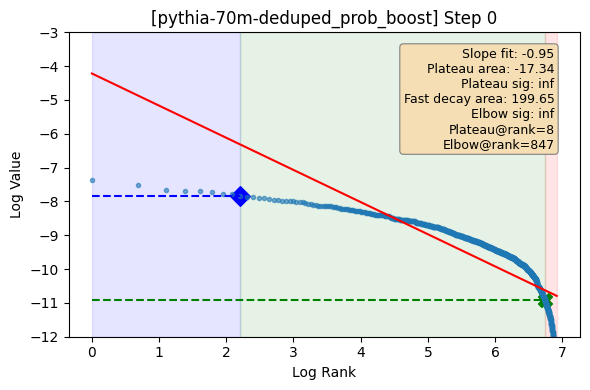

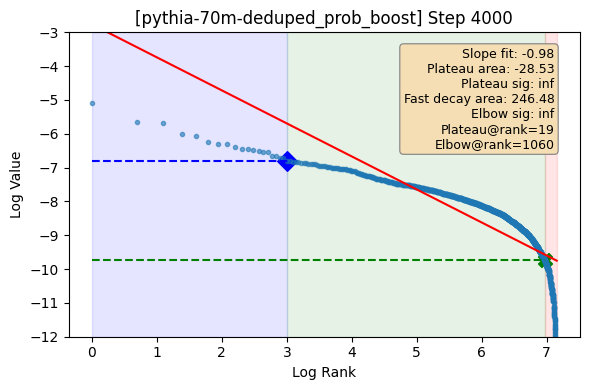

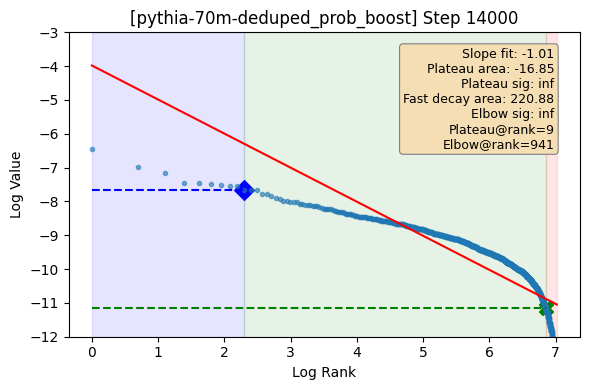

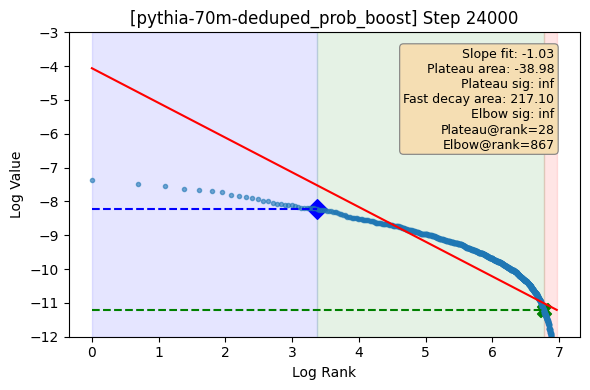

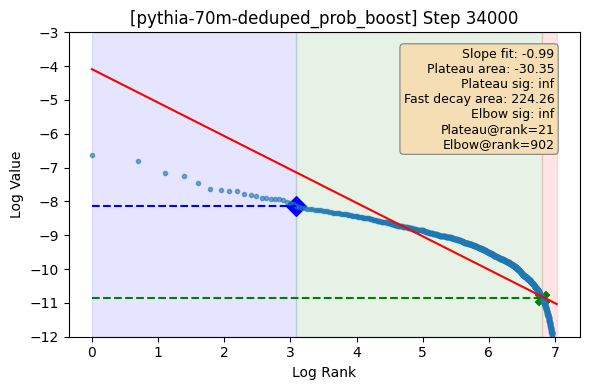

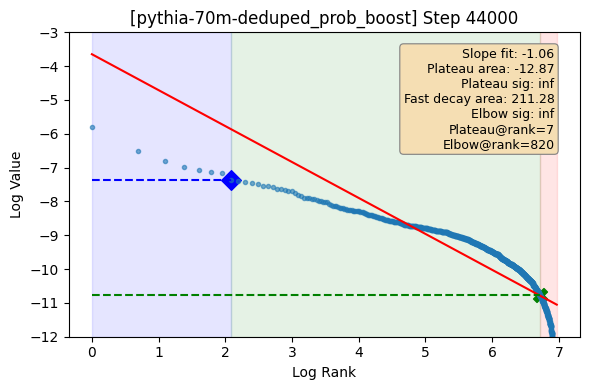

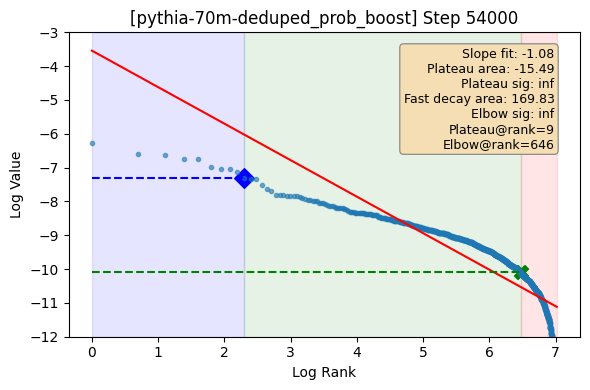

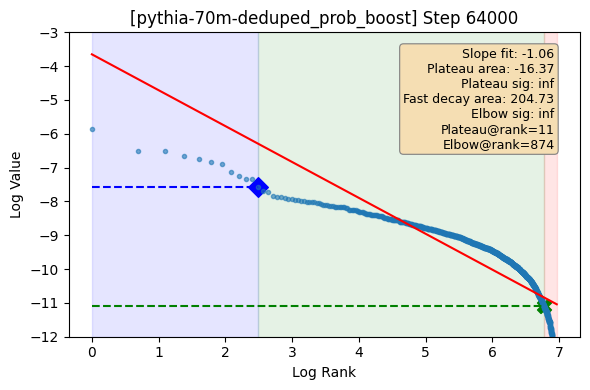

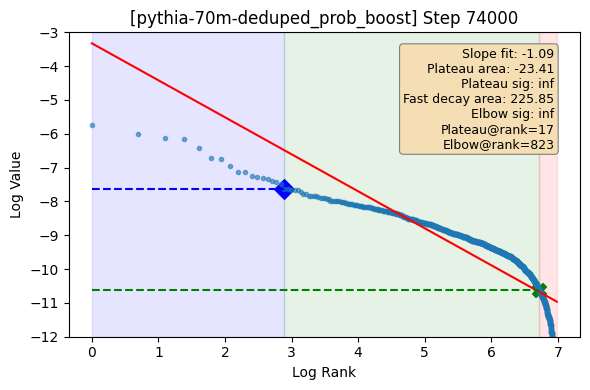

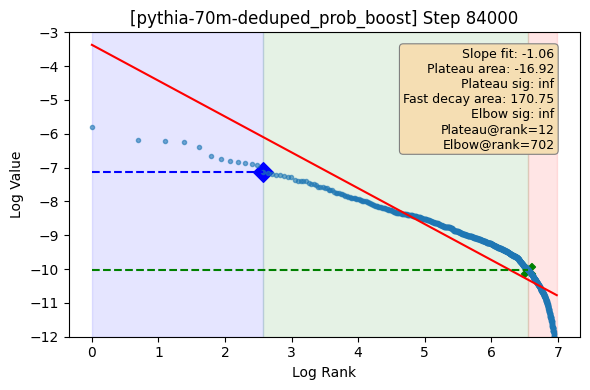

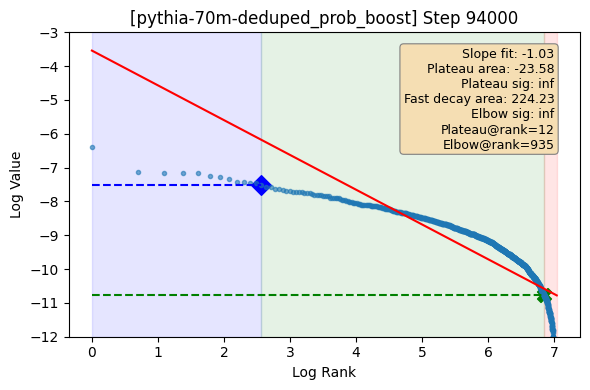

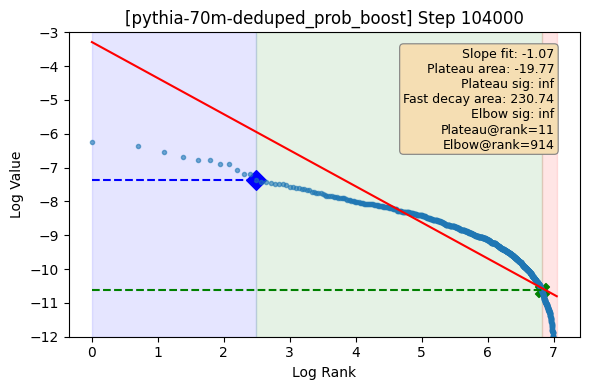

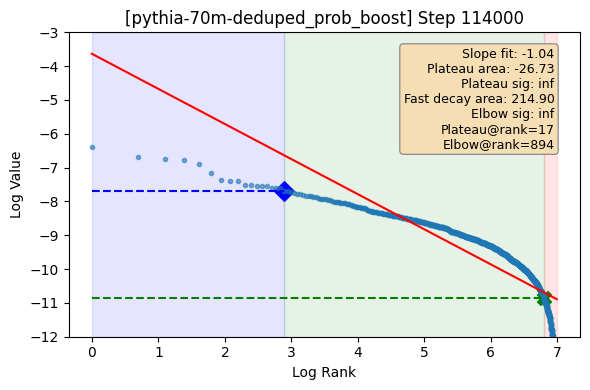

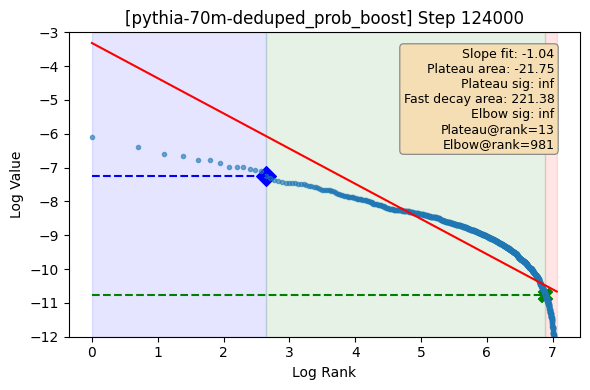

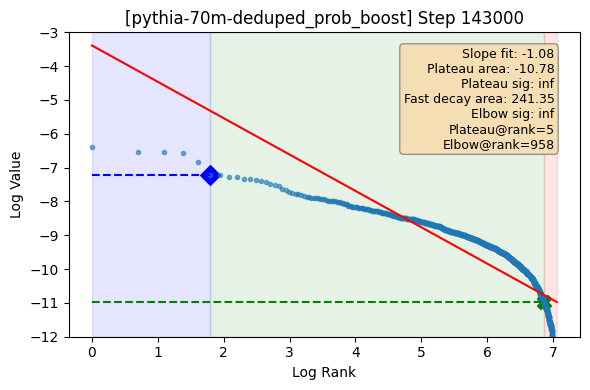

In [9]:
# Example usage:
optimized_plateau_params = {
   "window_size": 3,
   "threshold_multiplier": 0,
   "min_rank_percentile": 0.0,
   "max_log_rank": 3.5,
   "expected_direction": "positive"
}

optimized_elbow_params = {
   "window_size": 5,
   "threshold_multiplier": 0,
   "min_log_rank": 5.5,
   "max_log_rank": 7.5,
   "expected_direction": "negative"
}

file_metrics = run_analysis(
    root_dir=f"{ROOT_dir}/results/selection/neuron/common/EleutherAI",
    output_dir=f"{ROOT_dir}/fig/delta_loss",
    plateau_params=optimized_plateau_params,
    elbow_params=optimized_elbow_params,
    ylim=(-12, -3)  # Consistent y-axis limits
)




## Quick check on first derivatives

In [3]:
# check derivatives by steps
# get rank and values

def rank_val(values)->tuple[np.array,np.array]:
    """Analyze the distribution and identify both transition points using a unified approach. """
    arr = np.array(values)
    arr = arr[arr > 0]
    sorted_vals = np.sort(arr)[::-1]
    ranks = np.arange(1, len(sorted_vals)+1)
    return np.log(ranks), np.log(sorted_vals)


def plot_slope(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    window_size: int = 50,
) -> dict:
    """Get first derivatives of each step."""
    n = len(log_ranks)
    
    # Apply rank percentile constraints
    max_idx = min(int(len(log_ranks)), n - window_size)
    # Dynamic window size
    w = min(window_size, max(5, (max_idx - window_size) // 5))
    # Calculate first derivatives (slopes)
    derivatives, idxs = [], []
    for i in range(window_size, max_idx - w + 1):
        slope, _, _, _, _ = stats.linregress(
            log_ranks[i : i + w], log_vals[i : i + w]
        )
        derivatives.append(slope)
        idxs.append(i)
    derivatives = np.array(derivatives)
    return derivatives


def run_analysis(
    root_dir: str, 
    output_dir: str, 
    ylim: tuple = None,
    window_size: int = 50,
):
    """Batch process all 500_all.csv files in the directory,"""
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    
    
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        df["abs_delta_loss_post_ablation"] = df["abs_delta_loss_post_ablation"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        
        
        # Analyze each training step
        for _, row in df.iterrows():
            vals = row["abs_delta_loss_post_ablation"]
            log_ranks, log_vals = rank_val(vals)
            derivatives = plot_slope(log_ranks, log_vals)
            plt.plot(log_ranks[:-window_size],derivatives)
            plt.show()
            
            # Apply the unified approach with custom parameters
            print(len(log_ranks))
            
            

In [4]:
def plot_slope(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    window_size: int = 2,
) -> tuple[np.ndarray, np.ndarray]:
    """Get first derivatives of each step.
    
    Returns:
        tuple: (derivatives, indices) where derivatives are the slopes and 
               indices are the corresponding positions in the original array
    """
    n = len(log_ranks)
    # Apply rank percentile constraints
    max_idx = min(int(len(log_ranks)), n - window_size)
    # Dynamic window size
    w = min(window_size, max(5, (max_idx - window_size) // 5))

    # Calculate first derivatives (slopes)
    derivatives, idxs = [], []
    for i in range(window_size, max_idx - w + 1):
        slope, _, _, _, _ = stats.linregress(
            log_ranks[i : i + w*i], log_vals[i : i + w*i]
        )
        derivatives.append(slope)
        idxs.append(i)
    return np.array(derivatives), np.array(idxs)

def run_analysis(
    root_dir: str,
    output_dir: str,
    ylim: tuple = None,
    window_size = 5,
    step_lst = [],
):
    """Batch process all 500_all.csv files in the directory."""
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        df["abs_delta_loss_post_ablation"] = df["abs_delta_loss_post_ablation"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        
        # Analyze each training step
        
        for _, row in df.iterrows():
            vals = row["abs_delta_loss_post_ablation"]
            step = str(row["step"])
            log_ranks, log_vals = rank_val(vals)
            if step in step_lst:
                derivatives, idxs = plot_slope(log_ranks, log_vals, window_size)
                # Use the correct indices for plotting
                plt.plot(log_ranks[idxs], derivatives,label = step)
                print(len(log_ranks))
            
        plt.title(f"{rel_id}")
        plt.xlabel("Log rank")
        plt.ylabel("Slope")
        plt.ylim(ylim)
        plt.legend()
        plt.show()
        # Apply the unified approach with custom parameterswindow_size: int = 10,

1258
1059
1041
1146


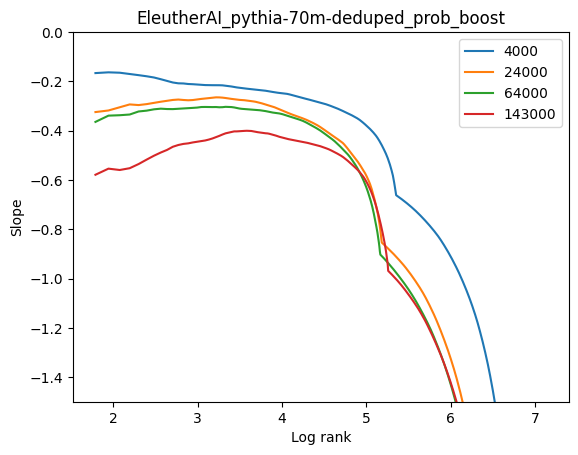

790
989
1007
902


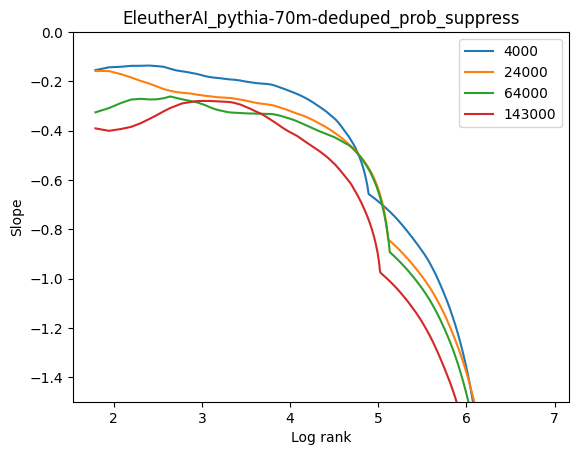

2106
2123
2146
2096


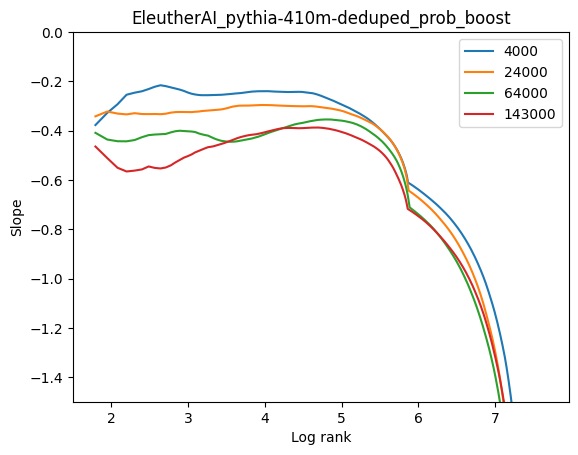

1990
1973
1950
2000


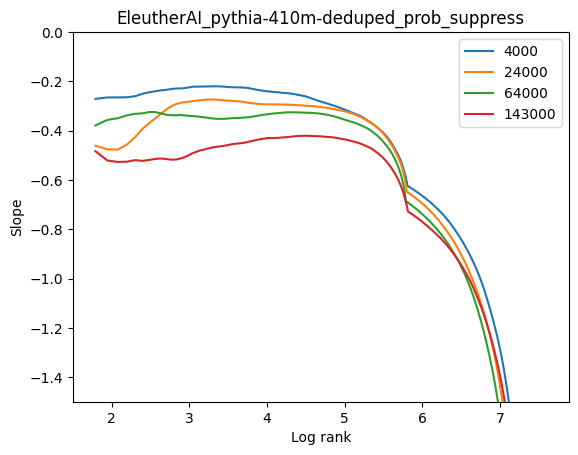

In [5]:
file_metrics = run_analysis(
    root_dir=f"{ROOT_dir}/results/selection/neuron/longtail_50",
    output_dir=f"{ROOT_dir}/fig/loss_slope",
    ylim=[-1.5,0],
    window_size = 5,
    step_lst = ["4000","24000", "64000","143000"]
)


# Fitted power law

In [113]:
def zipf_analysis(values: list[float]) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Analyze values using Zipf's law and return log-log data with power law fit."""
    arr = np.array(values)
    arr = arr[arr > 0]  # Remove zero/negative values
    sorted_vals = np.sort(arr)[::-1]  # Sort in descending order
    ranks = np.arange(1, len(sorted_vals) + 1)
    log_ranks = np.log(ranks)
    log_vals = np.log(sorted_vals)
    
    # Fit linear model in log-log space (power law)
    coeffs = np.polyfit(log_ranks, log_vals, deg=1)
    zipf_line = np.poly1d(coeffs)(log_ranks)
    
    return log_ranks, log_vals, zipf_line, coeffs


def plot_zipf_distribution(
    log_ranks: np.ndarray,
    log_vals: np.ndarray, 
    zipf_line: np.ndarray,
    coeffs: np.ndarray,
    title: str,
    save_path: Path,
    ylim: tuple[float, float] | None = None
) -> None:
    """Create a clean log-log plot showing the distribution and power law fit."""
    plt.figure(figsize=(8, 6))
    
    # Plot data points
    plt.plot(log_ranks, log_vals, 'o', color='blue', alpha=0.6, markersize=4)
    
    # Plot power law fit
    alpha = abs(coeffs[0])  # Power law exponent (absolute value)
    plt.plot(log_ranks, zipf_line, '-', color='green', linewidth=2, 
             label=f'Power-Law Predictions (α = {alpha:.2f})')
    
    # Styling
    plt.xlabel('Log Rank', fontsize=12)
    plt.ylabel('Log Value', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()


def run_zipf_analysis(
    root_dir: str,
    output_dir: str,
    ylim: tuple[float, float] | None = None
) -> dict[str, list[dict]]:
    """
    Process all CSV files and create Zipf distribution plots.
    
    Parameters:
    -----------
    root_dir: Directory containing CSV files with neuron influence data
    output_dir: Directory to save plots
    ylim: Y-axis limits (min, max) to unify plots across files
    
    Returns:
    --------
    Dictionary containing analysis results for each file
    """
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    
    # Store results
    results = {}
    
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        df["delta_loss_post"] = df["delta_loss_post"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        
        # Create file identifier
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        results[rel_id] = []
        
        # Analyze each training step
        for _, row in df.iterrows():
            step = row["step"]
            vals = row["delta_loss_post"]
            
            # Perform Zipf analysis
            log_ranks, log_vals, zipf_line, coeffs = zipf_analysis(vals)
            
            # Generate and save the plot
            title = f"[{rel_id}] Step {step}"
            save_path = output_path / f"{rel_id}_step{step}_zipf.png"
            plot_zipf_distribution(log_ranks, log_vals, zipf_line, coeffs, title, save_path, ylim)
            
            # Store results
            alpha = abs(coeffs[0])
            results[rel_id].append({
                "step": step,
                "alpha": alpha,
                "intercept": coeffs[1],
                "r_squared": calculate_r_squared(log_vals, zipf_line)
            })
    
    return results


def calculate_r_squared(y_actual: np.ndarray, y_predicted: np.ndarray) -> float:
    """Calculate R-squared for goodness of fit."""
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    return 1 - (ss_res / ss_tot)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import ast


def zipf_analysis(values: list[float]) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray] | None:
    """Analyze values using Zipf's law and return log-log data with power law fit."""
    arr = np.array(values)
    
    # Handle different data types and structures
    if arr.ndim > 1:
        arr = arr.flatten()
    
    # Remove non-finite values and filter positive values
    arr = arr[np.isfinite(arr)]
    positive_vals = arr[arr > 0]
    
    # Check if we have enough valid data points
    if len(positive_vals) < 10:
        print(f"Warning: Only {len(positive_vals)} positive values found, skipping analysis")
        return None
    
    sorted_vals = np.sort(positive_vals)[::-1]  # Sort in descending order
    ranks = np.arange(1, len(sorted_vals) + 1)
    log_ranks = np.log(ranks)
    log_vals = np.log(sorted_vals)
    
    # Fit linear model in log-log space (power law)
    coeffs = np.polyfit(log_ranks, log_vals, deg=1)
    zipf_line = np.poly1d(coeffs)(log_ranks)
    
    return log_ranks, log_vals, zipf_line, coeffs


def plot_zipf_distribution(
    log_ranks: np.ndarray,
    log_vals: np.ndarray, 
    zipf_line: np.ndarray,
    coeffs: np.ndarray,
    title: str,
    save_path: Path,
    ylim: tuple[float, float] | None = None
) -> None:
    """Create a clean log-log plot showing the distribution and power law fit."""
    plt.figure(figsize=(8, 6))
    
    # Plot data points
    plt.plot(log_ranks, log_vals, 'o', color='blue', alpha=0.6, markersize=4)
    
    # Plot power law fit
    alpha = abs(coeffs[0])  # Power law exponent (absolute value)
    plt.plot(log_ranks, zipf_line, '-', color='green', linewidth=2, 
             label=f'Power-Law Predictions (α = {alpha:.2f})')
    
    # Styling
    plt.xlabel('Log Rank', fontsize=12)
    plt.ylabel('Log Value', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()


def run_zipf_analysis(
    root_dir: str,
    output_dir: str,
    ylim: tuple[float, float] | None = None
) -> dict[str, list[dict]]:
    """
    Process all CSV files and create Zipf distribution plots.
    
    Parameters:
    -----------
    root_dir: Directory containing CSV files with neuron influence data
    output_dir: Directory to save plots
    ylim: Y-axis limits (min, max) to unify plots across files
    
    Returns:
    --------
    Dictionary containing analysis results for each file
    """
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    print(csv_files)
    # Store results
    results = {}
    
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        df["delta_loss_post"] = df["delta_loss_post"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        
        # Create file identifier
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        results[rel_id] = []
        
        # Analyze each training step
        for _, row in df.iterrows():
            step = row["step"]
            vals = row["abs_delta_loss_post"]
            
            # Debug: Check data structure
            print(f"Processing {rel_id}, Step {step}: {len(vals)} values, "
                  f"type: {type(vals)}, sample: {vals[:5] if len(vals) > 0 else 'empty'}")
            
            # Perform Zipf analysis
            analysis_result = zipf_analysis(vals)
            
            # Skip if analysis failed
            if analysis_result is None:
                print(f"Skipping {rel_id} Step {step} - insufficient valid data")
                continue
                
            log_ranks, log_vals, zipf_line, coeffs = analysis_result
            
            # Generate and save the plot
            title = f"[{rel_id}] Step {step}"
            save_path = output_path / f"{rel_id}_step{step}_zipf.png"
            plot_zipf_distribution(log_ranks, log_vals, zipf_line, coeffs, title, save_path, ylim)
            
            # Store results
            alpha = abs(coeffs[0])
            results[rel_id].append({
                "step": step,
                "alpha": alpha,
                "intercept": coeffs[1],
                "r_squared": calculate_r_squared(log_vals, zipf_line),
                "n_points": len(log_vals)
            })
    
    return results


def calculate_r_squared(y_actual: np.ndarray, y_predicted: np.ndarray) -> float:
    """Calculate R-squared for goodness of fit."""
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    return 1 - (ss_res / ss_tot)



In [15]:

root_directory = f"{ROOT_dir}/results/selection/neuron/common/EleutherAI"
output_directory = f"{ROOT_dir}/fig/delta_loss"
    
# Run analysis
results = run_zipf_analysis(root_directory, output_directory)
    
    # Print summary
for file_id, file_results in results.items():
    print(f"\n{file_id}:")
    for result in file_results:
        print(f"  Step {result['step']}: α = {result['alpha']:.3f}, R² = {result['r_squared']:.3f}")

Processing pythia-70m-deduped_prob_boost, Step 0: 1011 values, type: <class 'list'>, sample: [0.00014022191365559896, 0.00026491363843282064, 5.315144856770833e-06, 9.380420049031575e-05, 0.00014546751976013183]
Processing pythia-70m-deduped_prob_boost, Step 4000: 1280 values, type: <class 'list'>, sample: [0.006123698829399834, 0.0010087454990528118, 0.0017004482365030327, 0.00025269613540394045, 0.0019606169107623844]
Processing pythia-70m-deduped_prob_boost, Step 14000: 1115 values, type: <class 'list'>, sample: [0.001599968786508856, 0.0005275618902247643, 1.0495660743583344e-05, 0.0004728727350380316, 0.000471945984919027]
Processing pythia-70m-deduped_prob_boost, Step 24000: 1057 values, type: <class 'list'>, sample: [0.0005277591338419688, 0.00030000634265931077, 0.0005662288103962118, 0.00047741644953476145, 3.825670661484843e-05]
Processing pythia-70m-deduped_prob_boost, Step 34000: 1126 values, type: <class 'list'>, sample: [0.0013245239080576236, 7.1595250504591e-05, 0.00040

In [16]:
results

{'pythia-70m-deduped_prob_boost': [{'step': '0',
   'alpha': 0.9505175082277665,
   'intercept': -4.216818471036432,
   'r_squared': 0.6003639419428177,
   'n_points': 1011},
  {'step': '4000',
   'alpha': 0.9766293430219111,
   'intercept': -2.763081962029305,
   'r_squared': 0.6193571119646728,
   'n_points': 1280},
  {'step': '14000',
   'alpha': 1.0071064769681257,
   'intercept': -3.980479122813685,
   'r_squared': 0.611006431982229,
   'n_points': 1115},
  {'step': '24000',
   'alpha': 1.0261975376383623,
   'intercept': -4.061124254475926,
   'r_squared': 0.6223766074814394,
   'n_points': 1057},
  {'step': '34000',
   'alpha': 0.9883967887076927,
   'intercept': -4.088456406003733,
   'r_squared': 0.6239455164436701,
   'n_points': 1126},
  {'step': '44000',
   'alpha': 1.0625810460818474,
   'intercept': -3.646831277806296,
   'r_squared': 0.650595442879039,
   'n_points': 1063},
  {'step': '54000',
   'alpha': 1.0792518458799973,
   'intercept': -3.5410918138538423,
   'r_squ

## fit linear regions only


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import ast


def zipf_analysis(
    values: list[float], 
    fit_mode: str = "linear_region",
    linear_region: tuple[float, float] = (2.0, 5.0)
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray] | None:
    """
    Analyze values using Zipf's law with configurable fitting approach.
    
    Parameters:
    -----------
    values: Input values to analyze
    fit_mode: "linear_region" or "whole" - controls fitting approach
    linear_region: Log rank range (min, max) to use for linear region fitting
    
    Returns:
    --------
    Tuple of (log_ranks, log_vals, zipf_line, coeffs) or None if analysis fails
    """
    arr = np.array(values)
    
    # Handle different data types and structures
    if arr.ndim > 1:
        arr = arr.flatten()
    
    # Remove non-finite values and take absolute values
    arr = arr[np.isfinite(arr)]
    abs_vals = np.abs(arr)
    
    # Filter out zero values (can't take log of zero)
    positive_vals = abs_vals[abs_vals > 0]
    
    # Check if we have enough valid data points
    if len(positive_vals) < 10:
        print(f"Warning: Only {len(positive_vals)} positive values found, skipping analysis")
        return None
    
    sorted_vals = np.sort(positive_vals)[::-1]  # Sort in descending order
    ranks = np.arange(1, len(sorted_vals) + 1)
    log_ranks = np.log(ranks)
    log_vals = np.log(sorted_vals)
    
    # Choose fitting approach based on fit_mode
    if fit_mode == "linear_region":
        # Define linear region for fitting
        min_log_rank, max_log_rank = linear_region
        linear_mask = (log_ranks >= min_log_rank) & (log_ranks <= max_log_rank)
        
        # Check if we have enough points in the linear region
        if np.sum(linear_mask) < 5:
            print(f"Warning: Only {np.sum(linear_mask)} points in linear region, skipping analysis")
            return None
        
        # Fit linear model only to the linear region
        coeffs = np.polyfit(log_ranks[linear_mask], log_vals[linear_mask], deg=1)
    
    elif fit_mode == "whole":
        # Fit to the entire range
        coeffs = np.polyfit(log_ranks, log_vals, deg=1)
    
    else:
        raise ValueError(f"Invalid fit_mode: {fit_mode}. Use 'linear_region' or 'whole'")
    
    # Generate line for the entire range for visualization
    zipf_line = np.poly1d(coeffs)(log_ranks)
    
    return log_ranks, log_vals, zipf_line, coeffs




def plot_zipf_distribution1(
    log_ranks: np.ndarray,
    log_vals: np.ndarray, 
    zipf_line: np.ndarray,
    coeffs: np.ndarray,
    title: str,
    save_path: Path,
    fit_mode: str = "linear_region",
    linear_region: tuple[float, float] = (2.0, 5.0),
    ylim: tuple[float, float] | None = None
) -> None:
    """Create a clean log-log plot showing the distribution and power law fit."""
    plt.figure(figsize=(8, 6))
    
    # Plot data points
    plt.plot(log_ranks, log_vals, 'o', color='blue', alpha=0.6, markersize=4)
    
    # Highlight the linear region used for fitting if applicable
    if fit_mode == "linear_region":
        min_log_rank, max_log_rank = linear_region
        linear_mask = (log_ranks >= min_log_rank) & (log_ranks <= max_log_rank)
        if np.any(linear_mask):
            plt.plot(log_ranks[linear_mask], log_vals[linear_mask], 'o', 
                    color='darkblue', alpha=0.8, markersize=5, label='Fitted Region')
    
    # Plot power law fit (extended to full range)
    alpha = abs(coeffs[0])  # Power law exponent (absolute value)
    fit_label = f'Power-Law Predictions (α = {alpha:.2f})'
    if fit_mode == "linear_region":
        fit_label += ' [Linear Region Fit]'
    else:
        fit_label += ' [Whole Range Fit]'
    
    plt.plot(log_ranks, zipf_line, '-', color='green', linewidth=2, label=fit_label)
    
    # Styling
    plt.xlabel('Log Rank', fontsize=12)
    plt.ylabel('Log Value', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()




def plot_zipf_distribution(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    zipf_line: np.ndarray,
    coeffs: np.ndarray,
    title: str,
    save_path: Path,
    fit_mode: str = "linear_region",
    linear_region: tuple[float, float] = (2.0, 5.0),
    ylim: tuple[float, float] | None = None
) -> None:
    """Create a clean log-log plot showing the distribution and power law fit."""
    plt.figure(figsize=(12, 8))
    
    # Plot data points - default matplotlib blue
    plt.plot(log_ranks, log_vals, 'o', color='blue', alpha=1.0, markersize=5)
    
    # Plot power law fit line - default matplotlib green
    plt.plot(log_ranks, zipf_line, '-', color='green', linewidth=4, 
             label='Power-Law Predictions')
    
    # Styling to match the example figure with larger fonts
    plt.xlabel('Log Rank', fontsize=20, fontweight='bold')
    plt.ylabel('Log Value', fontsize=20, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Legend styling to match example with larger font
    plt.legend(fontsize=24, frameon=True, fancybox=True, shadow=False, 
              loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    # Tick styling with larger labels and control tick density
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # Control number of ticks to match example (roughly 8 ticks on x-axis, 5-6 on y-axis)
    plt.locator_params(axis='x', nbins=10)
    plt.locator_params(axis='y', nbins=10)
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    # Remove title to match the clean example figure
    # plt.title(title, fontsize=14)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()



    

def calculate_r_squared_for_fit(
    log_ranks: np.ndarray, 
    log_vals: np.ndarray, 
    zipf_line: np.ndarray,
    fit_mode: str = "linear_region",
    linear_region: tuple[float, float] = (2.0, 5.0)
) -> float:
    """Calculate R-squared for goodness of fit based on the fitting mode."""
    if fit_mode == "linear_region":
        min_log_rank, max_log_rank = linear_region
        fit_mask = (log_ranks >= min_log_rank) & (log_ranks <= max_log_rank)
    else:
        fit_mask = np.ones(len(log_ranks), dtype=bool)  # Use all points
    
    if np.sum(fit_mask) < 2:
        return 0.0
    
    y_actual = log_vals[fit_mask]
    y_predicted = zipf_line[fit_mask]
    
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    
    if ss_tot == 0:
        return 1.0
    
    return 1 - (ss_res / ss_tot)


def create_combined_summary_plot(
    file_results: list[dict],
    file_id: str,
    output_path: Path
) -> None:
    """Create a single plot with alpha, plateau count, and tail count vs training steps."""
    steps = np.array([result["step"] for result in file_results])
    alphas = np.array([result["alpha"] for result in file_results])
    plateau_counts = np.array([result["plateau_count"] for result in file_results])
    tail_counts = np.array([result["tail_count"] for result in file_results])
    
    # Create figure with secondary y-axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot alpha values on primary y-axis
    color1 = 'red'
    ax1.set_xlabel('Training Step', fontsize=12)
    ax1.set_ylabel('Alpha (Power Law Exponent)', color=color1, fontsize=14)
    line1 = ax1.plot(steps, alphas, 'o-', color=color1, linewidth=4, markersize=7, label='Alpha')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)
    
    # Create secondary y-axis for counts
    ax2 = ax1.twinx()
    color2 = 'blue'
    color3 = 'orange'
    ax2.set_ylabel('Number of Data Points', color='black', fontsize=14)
    
    line2 = ax2.plot(steps, plateau_counts, 's-', color=color2, linewidth=4, markersize=7, label='Plateau Count')
    line3 = ax2.plot(steps, tail_counts, '^-', color=color3, linewidth=4, markersize=7, label='Tail Count')
    
    # Combine legends
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right', fontsize=14)
    
    plt.title(f'[{file_id}] Alpha and Region Counts During Training', fontsize=14)
    plt.tight_layout()
    plt.savefig(output_path / f"{file_id}_combined_summary.png", dpi=300, bbox_inches='tight')
    plt.close()


def run_zipf_analysis(
    root_dir: str,
    output_dir: str,
    fit_mode: str = "linear_region",
    linear_region: tuple[float, float] = (3.5, 4.5),
    ylim: tuple[float, float] | None = None
) -> dict[str, list[dict]]:
    """
    Process all CSV files and create Zipf distribution plots plus summary plots.
    
    Parameters:
    -----------
    root_dir: Directory containing CSV files with neuron influence data
    output_dir: Directory to save plots
    fit_mode: "linear_region" or "whole" - controls how to fit the power law
    linear_region: Log rank range (min, max) to define regions and fitting
    ylim: Y-axis limits (min, max) to unify plots across files
    
    Returns:
    --------
    Dictionary containing analysis results for each file
    """
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    
    # Store results
    results = {}
    
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        df["delta_loss_post"] = df["delta_loss_post"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(int)  # Convert to int for proper sorting
        
        # Create file identifier
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        results[rel_id] = []
        
        print(f"Processing file: {rel_id} with {len(df)} rows")
        
        # Sort by step to ensure proper ordering
        df = df.sort_values('step')
        
        # Analyze each training step
        for _, row in df.iterrows():
            step = row["step"]
            vals = row["delta_loss_post"]
            
            # Debug: Check data structure
            print(f"  Step {step}: {len(vals)} values")
            
            # Perform Zipf analysis
            analysis_result = zipf_analysis(vals, fit_mode, linear_region)
            
            # Skip if analysis failed
            if analysis_result is None:
                print(f"  Skipping Step {step} - insufficient valid data")
                continue
                
            log_ranks, log_vals, zipf_line, coeffs = analysis_result
            
            # Calculate region sizes based on linear_region boundaries
            min_log_rank, max_log_rank = linear_region
            plateau_count = np.sum(log_ranks < min_log_rank)
            linear_count = np.sum((log_ranks >= min_log_rank) & (log_ranks <= max_log_rank))
            tail_count = np.sum(log_ranks > max_log_rank)
            
            # Generate and save the individual plot
            title = f"[{rel_id}] Step {step}"
            save_path = output_path / f"{rel_id}_step{step}_zipf.png"
            plot_zipf_distribution(log_ranks, log_vals, zipf_line, coeffs, title, save_path, fit_mode, linear_region, ylim)
            
            # Store results
            alpha = abs(coeffs[0])
            results[rel_id].append({
                "step": step,
                "alpha": alpha,
                "intercept": coeffs[1],
                "r_squared": calculate_r_squared_for_fit(log_ranks, log_vals, zipf_line, fit_mode, linear_region),
                "n_points": len(log_vals),
                "plateau_count": plateau_count,
                "linear_count": linear_count,
                "tail_count": tail_count
            })
        
        # Create combined summary plot for this file if we have multiple steps
        if len(results[rel_id]) > 1:
            create_combined_summary_plot(results[rel_id], rel_id, output_path)
    
    return results



In [124]:

def plot_zipf_distribution(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    zipf_line: np.ndarray,
    coeffs: np.ndarray,
    title: str,
    save_path: Path,
    fit_mode: str = "linear_region",
    linear_region: tuple[float, float] = (2.0, 5.0),
    ylim: tuple[float, float] | None = None
) -> None:
    """Create a clean log-log plot showing the distribution and power law fit."""
    plt.figure(figsize=(14, 8))
    
    # Plot data points - default matplotlib blue
    plt.plot(log_ranks, log_vals, 'o', color='blue', alpha=1.0, markersize=5)
    
    # Plot power law fit line - default matplotlib green
    plt.plot(log_ranks, zipf_line, '-', color='green', linewidth=4, 
             label='Power-Law Predictions')
    
    # Styling to match the example figure with larger fonts
    plt.xlabel('Log Rank', fontsize=32)
    plt.ylabel('Log Value', fontsize=32)
    plt.grid(True, alpha=0.3)
    
    # Legend styling to match example with larger font
    plt.legend(fontsize=24, frameon=True, fancybox=True, shadow=False, 
              loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    # Tick styling with larger labels and control tick density
    plt.tick_params(axis='both', which='major', labelsize=26)
    
    # Control number of ticks to match example (roughly 8 ticks on x-axis, 5-6 on y-axis)
    plt.locator_params(axis='x', nbins=10)
    plt.locator_params(axis='y', nbins=10)
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    # Remove title to match the clean example figure
    # plt.title(title, fontsize=14)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()




In [119]:

root_directory = f"{ROOT_dir}/results/selection/neuron/longtail_elbow/EleutherAI"
output_directory = f"{ROOT_dir}/fig/delta_loss_elbow"
linear_region = (3.5, 4.5)
# Run analysis
results = run_zipf_analysis(root_directory, output_directory,linear_region=linear_region,ylim=(-18,-7))
    
    # Print summary
for file_id, file_results in results.items():
    print(f"\n{file_id}:")
    for result in file_results:
        print(f"  Step {result['step']}: α = {result['alpha']:.3f}, R² = {result['r_squared']:.3f}")

Processing file: pythia-70m-deduped_prob_boost with 154 rows
  Step 0: 1019 values
  Step 1: 1034 values
  Step 2: 1070 values
  Step 4: 1055 values
  Step 8: 1011 values
  Step 16: 993 values
  Step 32: 802 values
  Step 64: 869 values
  Step 128: 720 values
  Step 256: 1003 values
  Step 512: 664 values
  Step 1000: 801 values
  Step 2000: 886 values
  Step 3000: 926 values
  Step 4000: 1126 values
  Step 5000: 1009 values
  Step 6000: 820 values
  Step 7000: 1017 values
  Step 8000: 869 values
  Step 9000: 1077 values
  Step 10000: 1100 values
  Step 11000: 971 values
  Step 12000: 1092 values
  Step 13000: 974 values
  Step 14000: 1115 values
  Step 15000: 1001 values
  Step 16000: 1081 values
  Step 17000: 870 values
  Step 18000: 1100 values
  Step 19000: 959 values
  Step 20000: 1047 values
  Step 21000: 979 values
  Step 22000: 1025 values
  Step 23000: 1102 values
  Step 24000: 932 values
  Step 25000: 1047 values
  Step 26000: 1102 values
  Step 27000: 992 values
  Step 28000

In [128]:
root_directory = f"{ROOT_dir}/results/selection/neuron/longtail_50/gpt2-large"
output_directory = f"{ROOT_dir}/fig/delta_50_gpt2-large"
linear_region = (3.5, 4.5)
# Run analysis
results = run_zipf_analysis(root_directory, output_directory,linear_region=linear_region)
    
    # Print summary
for file_id, file_results in results.items():
    print(f"\n{file_id}:")
    for result in file_results:
        print(f"  Step {result['step']}: α = {result['alpha']:.3f}, R² = {result['r_squared']:.3f}")

Processing file: prob_boost with 1 rows
  Step -1: 2629 values
Processing file: prob_suppress with 1 rows
  Step -1: 2491 values

prob_boost:
  Step -1: α = 0.534, R² = 0.995

prob_suppress:
  Step -1: α = 0.342, R² = 0.979


# comparison

In [52]:

def zipf_analysis(
    values: list[float], 
    fit_mode: str = "linear_region",
    linear_region: tuple[float, float] = (2.0, 5.0)
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray] | None:
    """
    Analyze values using Zipf's law with configurable fitting approach.
    
    Parameters:
    -----------
    values: Input values to analyze
    fit_mode: "linear_region" or "whole" - controls fitting approach
    linear_region: Log rank range (min, max) to use for linear region fitting
    
    Returns:
    --------
    Tuple of (log_ranks, log_vals, zipf_line, coeffs) or None if analysis fails
    """
    arr = np.array(values)
    
    # Handle different data types and structures
    if arr.ndim > 1:
        arr = arr.flatten()
    
    # Remove non-finite values and take absolute values
    arr = arr[np.isfinite(arr)]
    abs_vals = np.abs(arr)
    
    # Filter out zero values (can't take log of zero)
    positive_vals = abs_vals[abs_vals > 0]
    
    # Check if we have enough valid data points
    if len(positive_vals) < 10:
        print(f"Warning: Only {len(positive_vals)} positive values found, skipping analysis")
        return None
    
    sorted_vals = np.sort(positive_vals)[::-1]  # Sort in descending order
    ranks = np.arange(1, len(sorted_vals) + 1)
    log_ranks = np.log(ranks)
    log_vals = np.log(sorted_vals)
    
    # Choose fitting approach based on fit_mode
    if fit_mode == "linear_region":
        # Define linear region for fitting
        min_log_rank, max_log_rank = linear_region
        linear_mask = (log_ranks >= min_log_rank) & (log_ranks <= max_log_rank)
        
        # Check if we have enough points in the linear region
        if np.sum(linear_mask) < 5:
            print(f"Warning: Only {np.sum(linear_mask)} points in linear region, skipping analysis")
            return None
        
        # Fit linear model only to the linear region
        coeffs = np.polyfit(log_ranks[linear_mask], log_vals[linear_mask], deg=1)
    
    elif fit_mode == "whole":
        # Fit to the entire range
        coeffs = np.polyfit(log_ranks, log_vals, deg=1)
    
    else:
        raise ValueError(f"Invalid fit_mode: {fit_mode}. Use 'linear_region' or 'whole'")
    
    # Generate line for the entire range for visualization
    zipf_line = np.poly1d(coeffs)(log_ranks)
    
    return log_ranks, log_vals, zipf_line, coeffs



In [53]:
def plot_zipf_distribution(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    zipf_line: np.ndarray,
    coeffs: np.ndarray,
    label: str,
    color: str,  # <-- NEW PARAMETER
    fit_mode: str = "linear_region",
    linear_region: tuple[float, float] = (2.0, 5.0),
    ylim: tuple[float, float] | None = None
) -> None:
    """Plot a Zipf distribution on an existing figure."""
    
    # Plot data points
    plt.plot(log_ranks, log_vals, 'o', color=color, alpha=0.5, markersize=4)

    # Highlight the linear region used for fitting if applicable
    if fit_mode == "linear_region":
        min_log_rank, max_log_rank = linear_region
        linear_mask = (log_ranks >= min_log_rank) & (log_ranks <= max_log_rank)
        if np.any(linear_mask):
            plt.plot(log_ranks[linear_mask], log_vals[linear_mask], 'o', 
                     color=color, alpha=0.8, markersize=5)

    # Plot fitted Zipf line
    plt.plot(log_ranks, zipf_line, '-', color=color, linewidth=2, label=label)

    # Styling stays the same
    plt.xlabel('Log Rank', fontsize=12)
    plt.ylabel('Log Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    if ylim is not None:
        plt.ylim(ylim)


In [54]:

def load_data(file_path):
    df = pd.read_csv(file_path)
    df["delta_loss_post"] = df["delta_loss_post"].apply(ast.literal_eval)
    df["step"] = df["step"].astype(int)  # Convert to int for proper sorting

    # Sort by step to ensure proper ordering
    df = df.sort_values('step')
    row = df.iloc[-1]
    step = row["step"]
    vals = row["delta_loss_post"]

    # Perform Zipf analysis
    fit_mode = "linear_region"
    analysis_result = zipf_analysis(vals, fit_mode, linear_region)
    log_ranks, log_vals, zipf_line, coeffs = analysis_result
    return log_ranks, log_vals, zipf_line, coeffs
                    
 

In [75]:
# First figure: longtail_50
ylim = (-12,0)
label_longtail = "longtail_50"
file_path_longtail = f"{ROOT_dir}/results/selection/neuron/{label_longtail}/EleutherAI/pythia-410m-deduped/prob/boost/500_all.csv"
linear_region_longtail = (3.5, 5.5)
log_ranks_longtail, log_vals_longtail, zipf_line_longtail, coeffs_longtail = load_data(file_path_longtail)

# Second figure: common
label_common = "common"
file_path_common = f"{ROOT_dir}/results/selection/neuron/{label_common}/EleutherAI/pythia-410m-deduped/prob/boost/500_all.csv"
linear_region_common = (3.5, 5.5)
log_ranks_common, log_vals_common, zipf_line_common, coeffs_common = load_data(file_path_common)


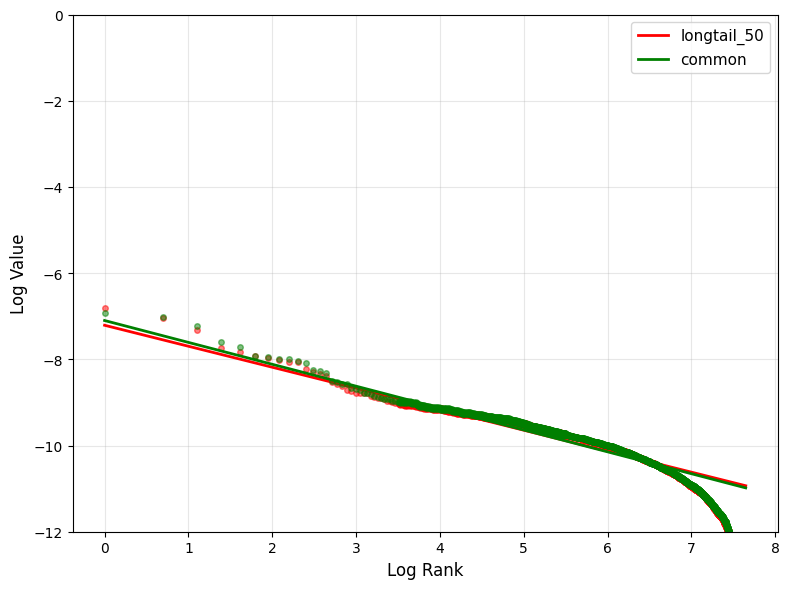

In [76]:
# Create one figure for both datasets
plt.figure(figsize=(8, 6))

# Longtail_50 — use red
plot_zipf_distribution(
    log_ranks_longtail, log_vals_longtail, zipf_line_longtail, coeffs_longtail,
    label_longtail, color="red", linear_region=linear_region_longtail,ylim=ylim
)

# Common — use blue
plot_zipf_distribution(
    log_ranks_common, log_vals_common, zipf_line_common, coeffs_common,
    label_common, color="green", linear_region=linear_region_common,ylim=ylim
)

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()
